# Calculate distance to cell center for every pixel

In [30]:
import numpy as np
import pandas as pd
import scipy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from joblib import Parallel, delayed
import os
import sys
import pickle
import skimage
import skimage.filters

sns.set(font_scale = 2)
sns.set_style('white')

### Directories and inputs

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from config import *

In [5]:
# dataframes of interest:
pickle_name_temp = f"{data_path_masked_BM}/images_all_BM.pickle"
images_all_BM = pickle.load(open(pickle_name_temp, "rb"))
pickle_name_temp = f"{data_path_masked_UC}/images_all_UC.pickle"
images_all_UC = pickle.load(open(pickle_name_temp, "rb"))

In [6]:
# Figures location    
save_path = f"{data_figure}/ksTest/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Load the datasets

In [7]:
pickle_name_temp = f"{data_path_masked_BM}/image_list_BM.pickle"
zoomed_image_list_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/image_list_UC.pickle"
zoomed_image_list_UC = pickle.load(open(pickle_name_temp, "rb"))

In [8]:
pickle_name_temp = f"{data_path_masked_BM}/mask_list_BM.pickle"
zoomed_mask_BM = pickle.load(open(pickle_name_temp, "rb"))

pickle_name_temp = f"{data_path_masked_UC}/mask_list_UC.pickle"
zoomed_mask_UC = pickle.load(open(pickle_name_temp, "rb"))

In [9]:
idCols = ['cell', 'index_i', 'index_j', 'CellType']

### Calculate centers of cells

In [10]:
list_centers_ph_BM = []
list_centers_ph_UC = []

for cell in range(len(zoomed_image_list_BM)):       
    mask_temp = zoomed_mask_BM[cell].copy()/255
    y, x = np.where(mask_temp > 0)
    center_temp = [np.mean(y), np.mean(x)]
    list_centers_ph_BM.append(center_temp)

for cell in range(len(zoomed_image_list_UC)):       
    mask_temp = zoomed_mask_UC[cell].copy()/255
    y, x = np.where(mask_temp > 0)
    center_temp = [np.mean(y), np.mean(x)]
    list_centers_ph_UC.append(center_temp)

### load images and threshold all signal with Otsu

In [11]:
def minMaxScaleThreshold(img, thresh):
    img = np.true_divide(img - np.min(img), \
                        np.zeros_like(img) + np.max(img) - np.min(img))
    img[img < thresh] = 0
    
    return img

# apply threshold
def applyThresholdMethod(img, choice):
    threshVal = 0
    
    if choice == 'Otsu':
        threshVal = skimage.filters.threshold_otsu(img)
        
    elif choice == 'Isodata':
        threshVal = skimage.filters.threshold_isodata(img)
        
    elif choice == 'Li':
        threshVal = skimage.filters.threshold_li(img)
        
    elif choice == 'Mean':
        threshVal = skimage.filters.threshold_mean(img)
        
    elif choice == 'Minimum':
        threshVal = skimage.filters.threshold_minimum(img)
        
    elif choice == 'Triangle':
        threshVal = skimage.filters.threshold_triangle(img)
        
    elif choice == 'Yen':
        threshVal = skimage.filters.threshold_yen(img)
        
    else:
        print('Threshold Method not found...')        
    
    return threshVal

In [12]:
threshChoice = 'Otsu'

In [13]:
# load BM images and threshold
images_all_BM = pd.DataFrame(columns = idCols)
for ii, cellNum in enumerate(tqdm(BM_indices)):
    image_array_temp = zoomed_image_list_BM[cellNum].copy()
    
    for jj, chName in enumerate(channel_names):
        
        image_array_temp_1 = image_array_temp[jj].copy()
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image_array_temp_1, choice = threshChoice)
        image_array_temp_1[image_array_temp_1 < threshVal] = 0
        
        # convert to dataframe
        y, x = np.where(image_array_temp_1 > 0) # thresholded coords
        gray = image_array_temp_1[image_array_temp_1 > 0] # gray values, same but fewer

        # update dataframe record
        dfSub = pd.DataFrame()
        dfSub['index_j'] = y
        dfSub['index_i'] = x
        dfSub[chName] = gray
        dfSub['CellType'] = np.repeat(['BM'], len(y))
        dfSub['cell'] = np.repeat([ii], len(y))
        
        # merge dataframes
        images_all_BM = images_all_BM.merge(dfSub, how = 'outer') 
        
# rename dataframe 
images_all_BM.fillna(0, inplace = True) # replace nans wt background
# combine duplicate coords, sum signals
images_all_BM = images_all_BM.groupby(idCols).sum().reset_index()

# load UC images and threshold
images_all_UC = pd.DataFrame(columns = idCols)
for ii, cellNum in enumerate(tqdm(UC_indices)):
    image_array_temp = zoomed_image_list_UC[cellNum].copy()
    
    for jj, chName in enumerate(channel_names):
        
        image_array_temp_1 = image_array_temp[jj].copy()
        
        # do Otsu, Yen, Triangle, thresholding
        threshVal = applyThresholdMethod(image_array_temp_1, choice = threshChoice)
        image_array_temp_1[image_array_temp_1 < threshVal] = 0
        
        # convert to dataframe
        y, x = np.where(image_array_temp_1 > 0) # thresholded coords
        gray = image_array_temp_1[image_array_temp_1 > 0] # gray values, same but fewer

        # update dataframe record
        dfSub = pd.DataFrame()
        dfSub['index_j'] = y
        dfSub['index_i'] = x
        dfSub[chName] = gray
        dfSub['CellType'] = np.repeat(['UC'], len(y))
        dfSub['cell'] = np.repeat([ii], len(y))
        
        # merge dataframes
        images_all_UC = images_all_UC.merge(dfSub, how = 'outer') 
        
# rename dataframe 
images_all_UC.fillna(0, inplace = True) # replace nans wt background
# combine duplicate coords, sum signals
images_all_UC = images_all_UC.groupby(idCols).sum().reset_index()


100%|█████████████████████████████████████████████████████████████| 7/7 [02:31<00:00, 21.64s/it]


In [14]:
# markers = images_all_BM.drop(columns = idCols).columns.tolist()

# # threshold BM with Otsu
# threshBM = pd.DataFrame(columns = images_all_BM.columns)
# for ii, c in enumerate(tqdm(images_all_BM['cell'].drop_duplicates())): # each cell

#     dfCell = images_all_BM.loc[images_all_BM['cell'] == c]
    
#     # each marker
#     for jj, m in enumerate(markers): # each marker
        
#         dfMarker = dfCell.loc[dfCell[m] > 0]
        
#         # create image to threshold
#         y = dfMarker['index_j'].values.astype(int)
#         x = dfMarker['index_i'].values.astype(int)
        
#         image_array_temp_1 = np.zeros([np.max(y) + 1, np.max(x) + 1])
#         image_array_temp_1[y, x] = dfMarker[m]
        
#         # threshold image
#         threshVal = applyThresholdMethod(image_array_temp_1, choice = threshChoice)
#         image_array_temp_1[image_array_temp_1 < threshVal] = 0
        
#         y, x = np.where(image_array_temp_1 > 0) # thresholded coords
#         gray = image_array_temp_1[image_array_temp_1 > 0] # gray values, same but fewer
        
#         # update dataframe record
#         dfSub = pd.DataFrame()
#         dfSub['index_j'] = y
#         dfSub['index_i'] = x
#         dfSub[m] = gray
#         dfSub['CellType'] = np.repeat(['BM'], len(y))
#         dfSub['cell'] = np.repeat([c], len(y))
        
#         # merge dataframes
#         threshBM = threshBM.merge(dfSub, how = 'outer')        
        
# # rename dataframe 
# images_all_BM = threshBM.copy(deep = True)
# images_all_BM.fillna(0, inplace = True) # replace nans wt background
# # combine duplicate coords, sum signals
# images_all_BM = images_all_BM.groupby(idCols).sum().reset_index()
                
# # threshold UC with Otsu
# threshUC = pd.DataFrame(columns = images_all_UC.columns)
# for ii, c in enumerate(tqdm(images_all_UC['cell'].drop_duplicates())): # each cell

#     dfCell = images_all_UC.loc[images_all_UC['cell'] == c]
    
#     # each marker
#     for jj, m in enumerate(markers): # each marker
        
#         dfMarker = dfCell.loc[dfCell[m] > 0]
        
#         # create image to threshold
#         y = dfMarker['index_j'].values.astype(int)
#         x = dfMarker['index_i'].values.astype(int)
        
#         image_array_temp_1 = np.zeros([np.max(y) + 1, np.max(x) + 1])
#         image_array_temp_1[y, x] = dfMarker[m]
        
#         # threshold image
#         threshVal = applyThresholdMethod(image_array_temp_1, choice = threshChoice)
#         image_array_temp_1[image_array_temp_1 < threshVal] = 0
        
#         y, x = np.where(image_array_temp_1 > 0) # thresholded coords
#         gray = image_array_temp_1[image_array_temp_1 > 0] # gray values, same but fewer
        
#         # update dataframe record
#         dfSub = pd.DataFrame()
#         dfSub['index_j'] = y
#         dfSub['index_i'] = x
#         dfSub[m] = gray
#         dfSub['CellType'] = np.repeat(['UC'], len(y))
#         dfSub['cell'] = np.repeat([c], len(y))
        
#         # merge dataframes
#         threshUC = threshUC.merge(dfSub, how = 'outer')
        
# # rename dataframe 
# images_all_UC = threshUC.copy(deep = True)
# images_all_UC.fillna(0, inplace = True) # replace nans wt background
# # combine duplicate coords, sum signals
# images_all_UC = images_all_UC.groupby(idCols).sum().reset_index()

### Compute distance to cell centers for BM cells

In [15]:
# compute cell center and distance by cell for BM cells
def calcDist(px, center, pts):
    d = np.linalg.norm(pts[px, :] - center)
    
    return d

In [16]:
distCenter = pd.DataFrame(columns = ['DistCenter'])

for ii, c in enumerate(tqdm(images_all_BM['cell'].drop_duplicates())):
    
    dfCell = images_all_BM.loc[images_all_BM['cell'] == c]
    
    # compute cell center from MASK
    center = list_centers_ph_BM[BM_indices[ii]]
    center = np.array(center)
    # center = dfCell[idCols]
    # center = dfCell.groupby(['cell']).mean() # avg XY coords
    # center = center[['index_i', 'index_j']].values 
    
    pts = dfCell[['index_i', 'index_j']].values # all coords
    
    dists = Parallel(n_jobs = -1, prefer = 'threads', verbose = 0)\
        (delayed(calcDist)(p, center, pts) for p in range(pts.shape[0]))

    dfDist = pd.DataFrame()
    dfDist['DistCenter'] = dists
    dfDist.index = dfCell.index
    
    distCenter = pd.concat([distCenter, dfDist])
    
    
# merge back with original DF
images_all_BM = images_all_BM.merge(distCenter, how = 'outer', \
                                    left_index = True, \
                                        right_index = True)

100%|█████████████████████████████████████████████████████████████| 7/7 [01:10<00:00, 10.10s/it]


In [17]:
images_all_BM

,cell,index_i,index_j,CellType,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA,DistCenter
0,0,43,115,BM,0.0,0.0,0.0,0.0,0.0,41.249710,0.0,0.000000,0.0,0.000000,0.0,216.925512
1,0,43,116,BM,0.0,0.0,0.0,0.0,0.0,42.915331,0.0,0.000000,0.0,0.000000,0.0,216.312033
2,0,44,115,BM,0.0,0.0,0.0,0.0,0.0,44.716921,0.0,0.000000,0.0,0.000000,0.0,216.137794
3,0,44,116,BM,0.0,0.0,0.0,0.0,0.0,42.439439,0.0,0.000000,0.0,0.000000,0.0,215.522073
4,0,45,115,BM,0.0,0.0,0.0,0.0,0.0,38.462344,0.0,0.000000,0.0,0.000000,0.0,215.351838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485944,6,1003,152,BM,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,43.441347,0.0,13.941717,0.0,745.158942
1485945,6,1003,153,BM,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,44.260995,0.0,14.102852,0.0,744.776462
1485946,6,1004,150,BM,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,53.277123,0.0,7.657463,0.0,746.850208
1485947,6,1004,151,BM,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,39.889538,0.0,13.458313,0.0,746.465916


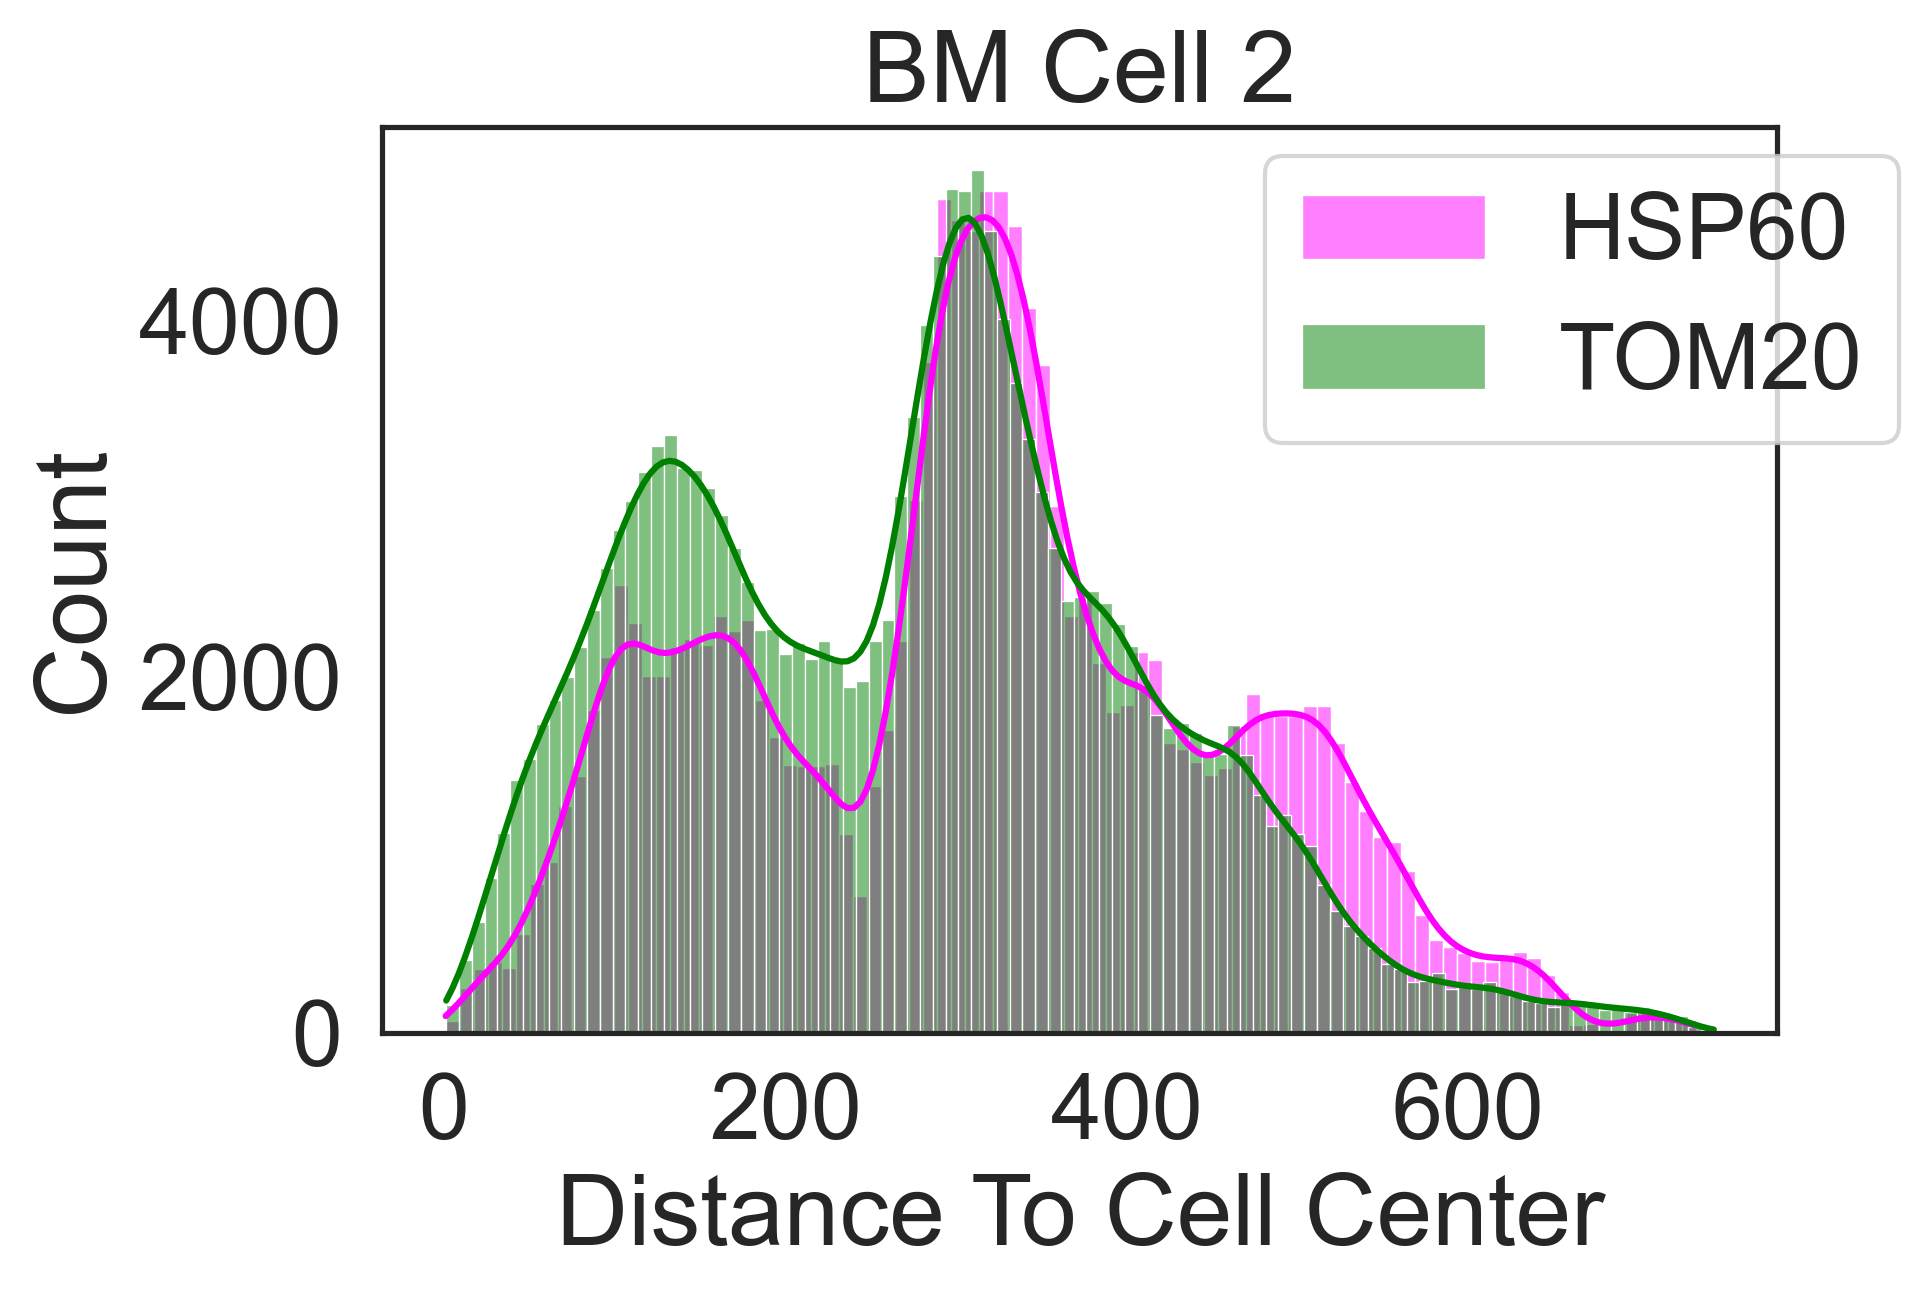

In [56]:
# plot example of distance to cell center
cellSelect = 1 # 0 indexing
fig, ax = plt.subplots(dpi = 300)
dists = images_all_BM.loc[(images_all_BM['HSP60'] > 0) &
                         (images_all_BM['cell'] == cellSelect)]
sns.histplot(dists, x = 'DistCenter', kde = True, label = 'HSP60', color = 'magenta')
dists = images_all_BM.loc[(images_all_BM['TOM20'] > 0) &
                         (images_all_BM['cell'] == cellSelect)]
sns.histplot(dists, x = 'DistCenter', kde = True, label = 'TOM20', color = 'green')

ax.set_xlabel('Distance To Cell Center')
ax.set_title('BM Cell ' + str(cellSelect + 1))
ax.legend(bbox_to_anchor = (0.6, 0.6))

# save fig
fileOut = 'BM_cell' + str(cellSelect + 1) + '_dist_centers_hist.png'
fileOut = os.path.join(save_path, fileOut)
plt.savefig(fileOut, dpi = 'figure', bbox_inches = 'tight')

### Compute distance to cell centers for UC cells

In [18]:
distCenter = pd.DataFrame(columns = ['DistCenter'])


for ii, c in enumerate(tqdm(images_all_UC['cell'].drop_duplicates())):
    
    dfCell = images_all_UC.loc[images_all_UC['cell'] == c]
    
    # compute cell center
    center = list_centers_ph_BM[BM_indices[ii]]
    center = np.array(center)
    # center = dfCell[idCols]
    # center = dfCell.groupby(['cell']).mean() # avg XY coords
    # center = center[['index_i', 'index_j']].values 
    
    pts = dfCell[['index_i', 'index_j']].values
    
    dists = Parallel(n_jobs = -1, prefer = 'threads', verbose = 0)\
        (delayed(calcDist)(p, center, pts) for p in range(pts.shape[0]))

    dfDist = pd.DataFrame()
    dfDist['DistCenter'] = dists
    dfDist.index = dfCell.index
    
    distCenter = pd.concat([distCenter, dfDist])
    

# merge back with original DF
images_all_UC = images_all_UC.merge(distCenter, how = 'outer', \
                                    left_index = True, \
                                        right_index = True)


100%|█████████████████████████████████████████████████████████████| 7/7 [01:55<00:00, 16.47s/it]


In [19]:
images_all_UC

,cell,index_i,index_j,CellType,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA,DistCenter
0,0,0,1319,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.830761,0.0,0.0,0.0,1091.800273
1,0,0,1320,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.780559,0.0,0.0,0.0,1092.780881
2,0,0,1321,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.028333,0.0,0.0,0.0,1093.761524
3,0,0,1322,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.268817,0.0,0.0,0.0,1094.742202
4,0,0,1323,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.961937,0.0,0.0,0.0,1095.722916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2490625,6,944,300,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.499669,0.0,0.0,0.0,644.155286
2490626,6,945,282,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.769394,0.0,0.0,0.0,649.205151
2490627,6,945,293,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.057773,0.0,0.0,0.0,646.659698
2490628,6,946,282,UC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.063991,0.0,0.0,0.0,650.176110


### Calculate pairwise markers w/in cell to validate 

In [20]:
def add_value_labels(ax, label, spacing):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for ii, rect in enumerate(ax.patches):
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Create annotation
        ax.annotate(
            label[ii],                  # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.54it/s]
C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_97848/3479713352.py:76: RuntimeWarning: divide by zero encountered in log10
  centerPVal['BM'] = -1 * np.log10(np.array(centerPVal['BM']))
C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_97848/3479713352.py:77: RuntimeWarning: divide by zero encountered in log10
  centerPVal['UC'] = -1 * np.log10(np.array(centerPVal['UC']))


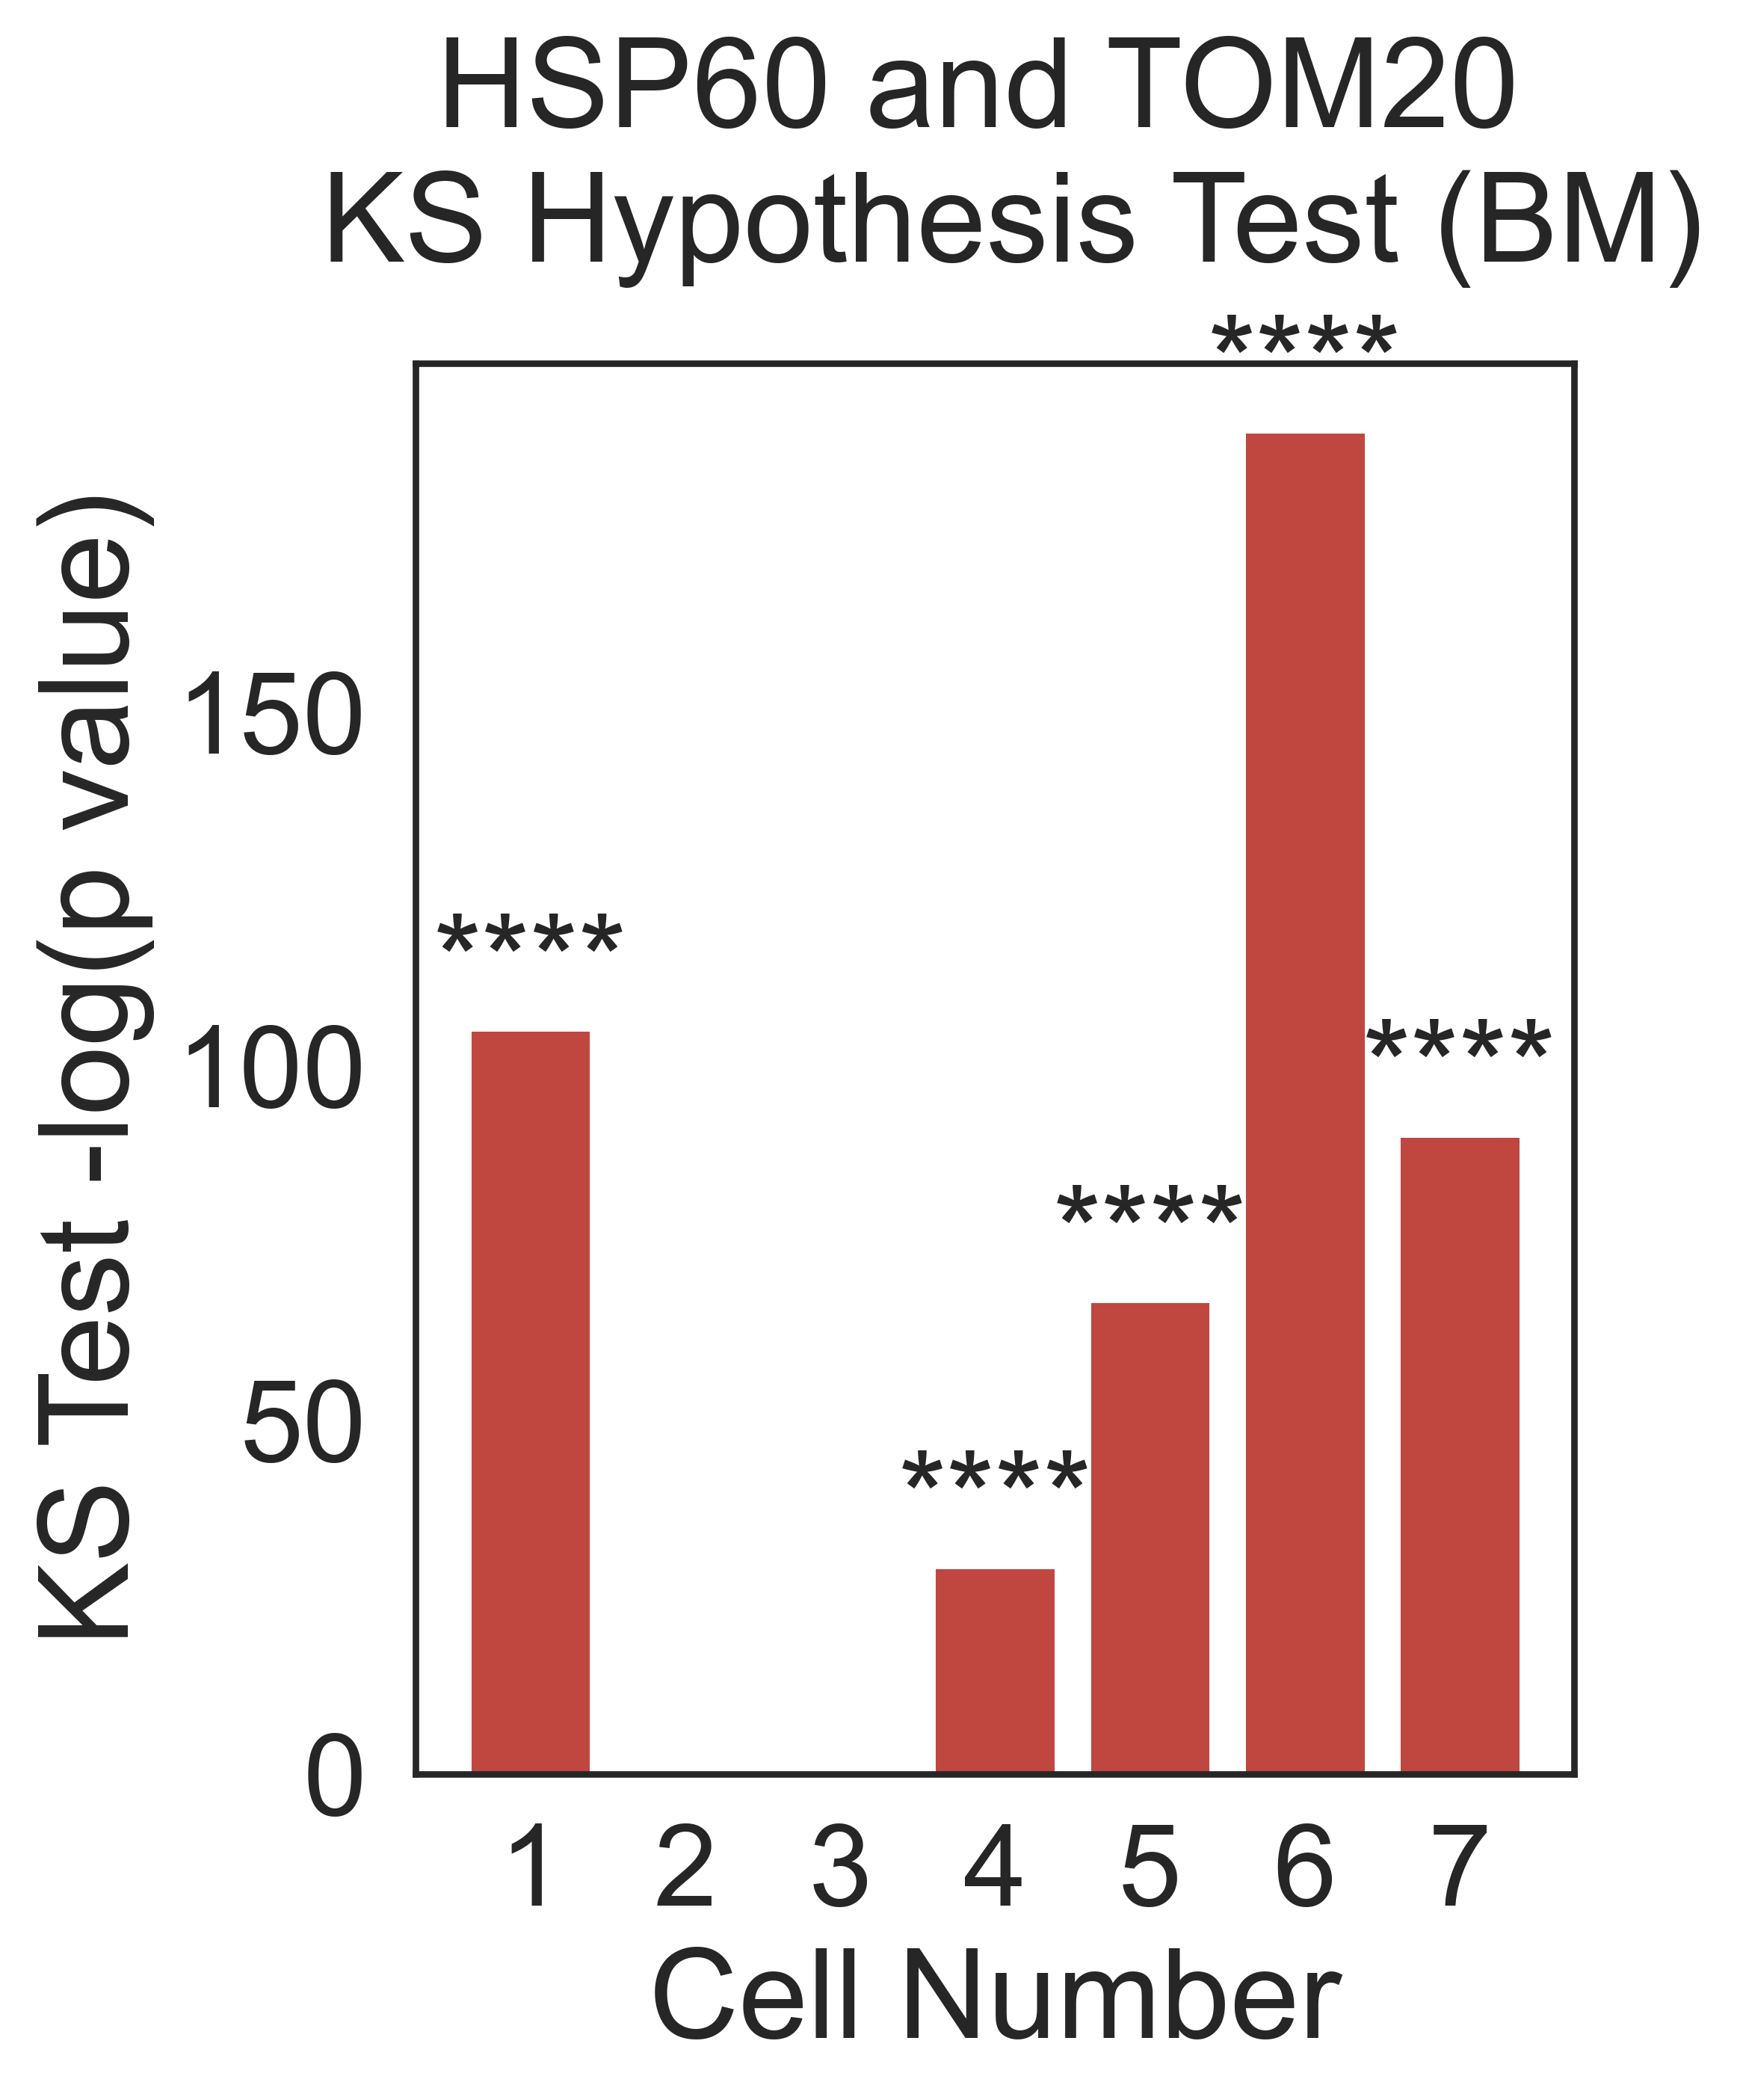

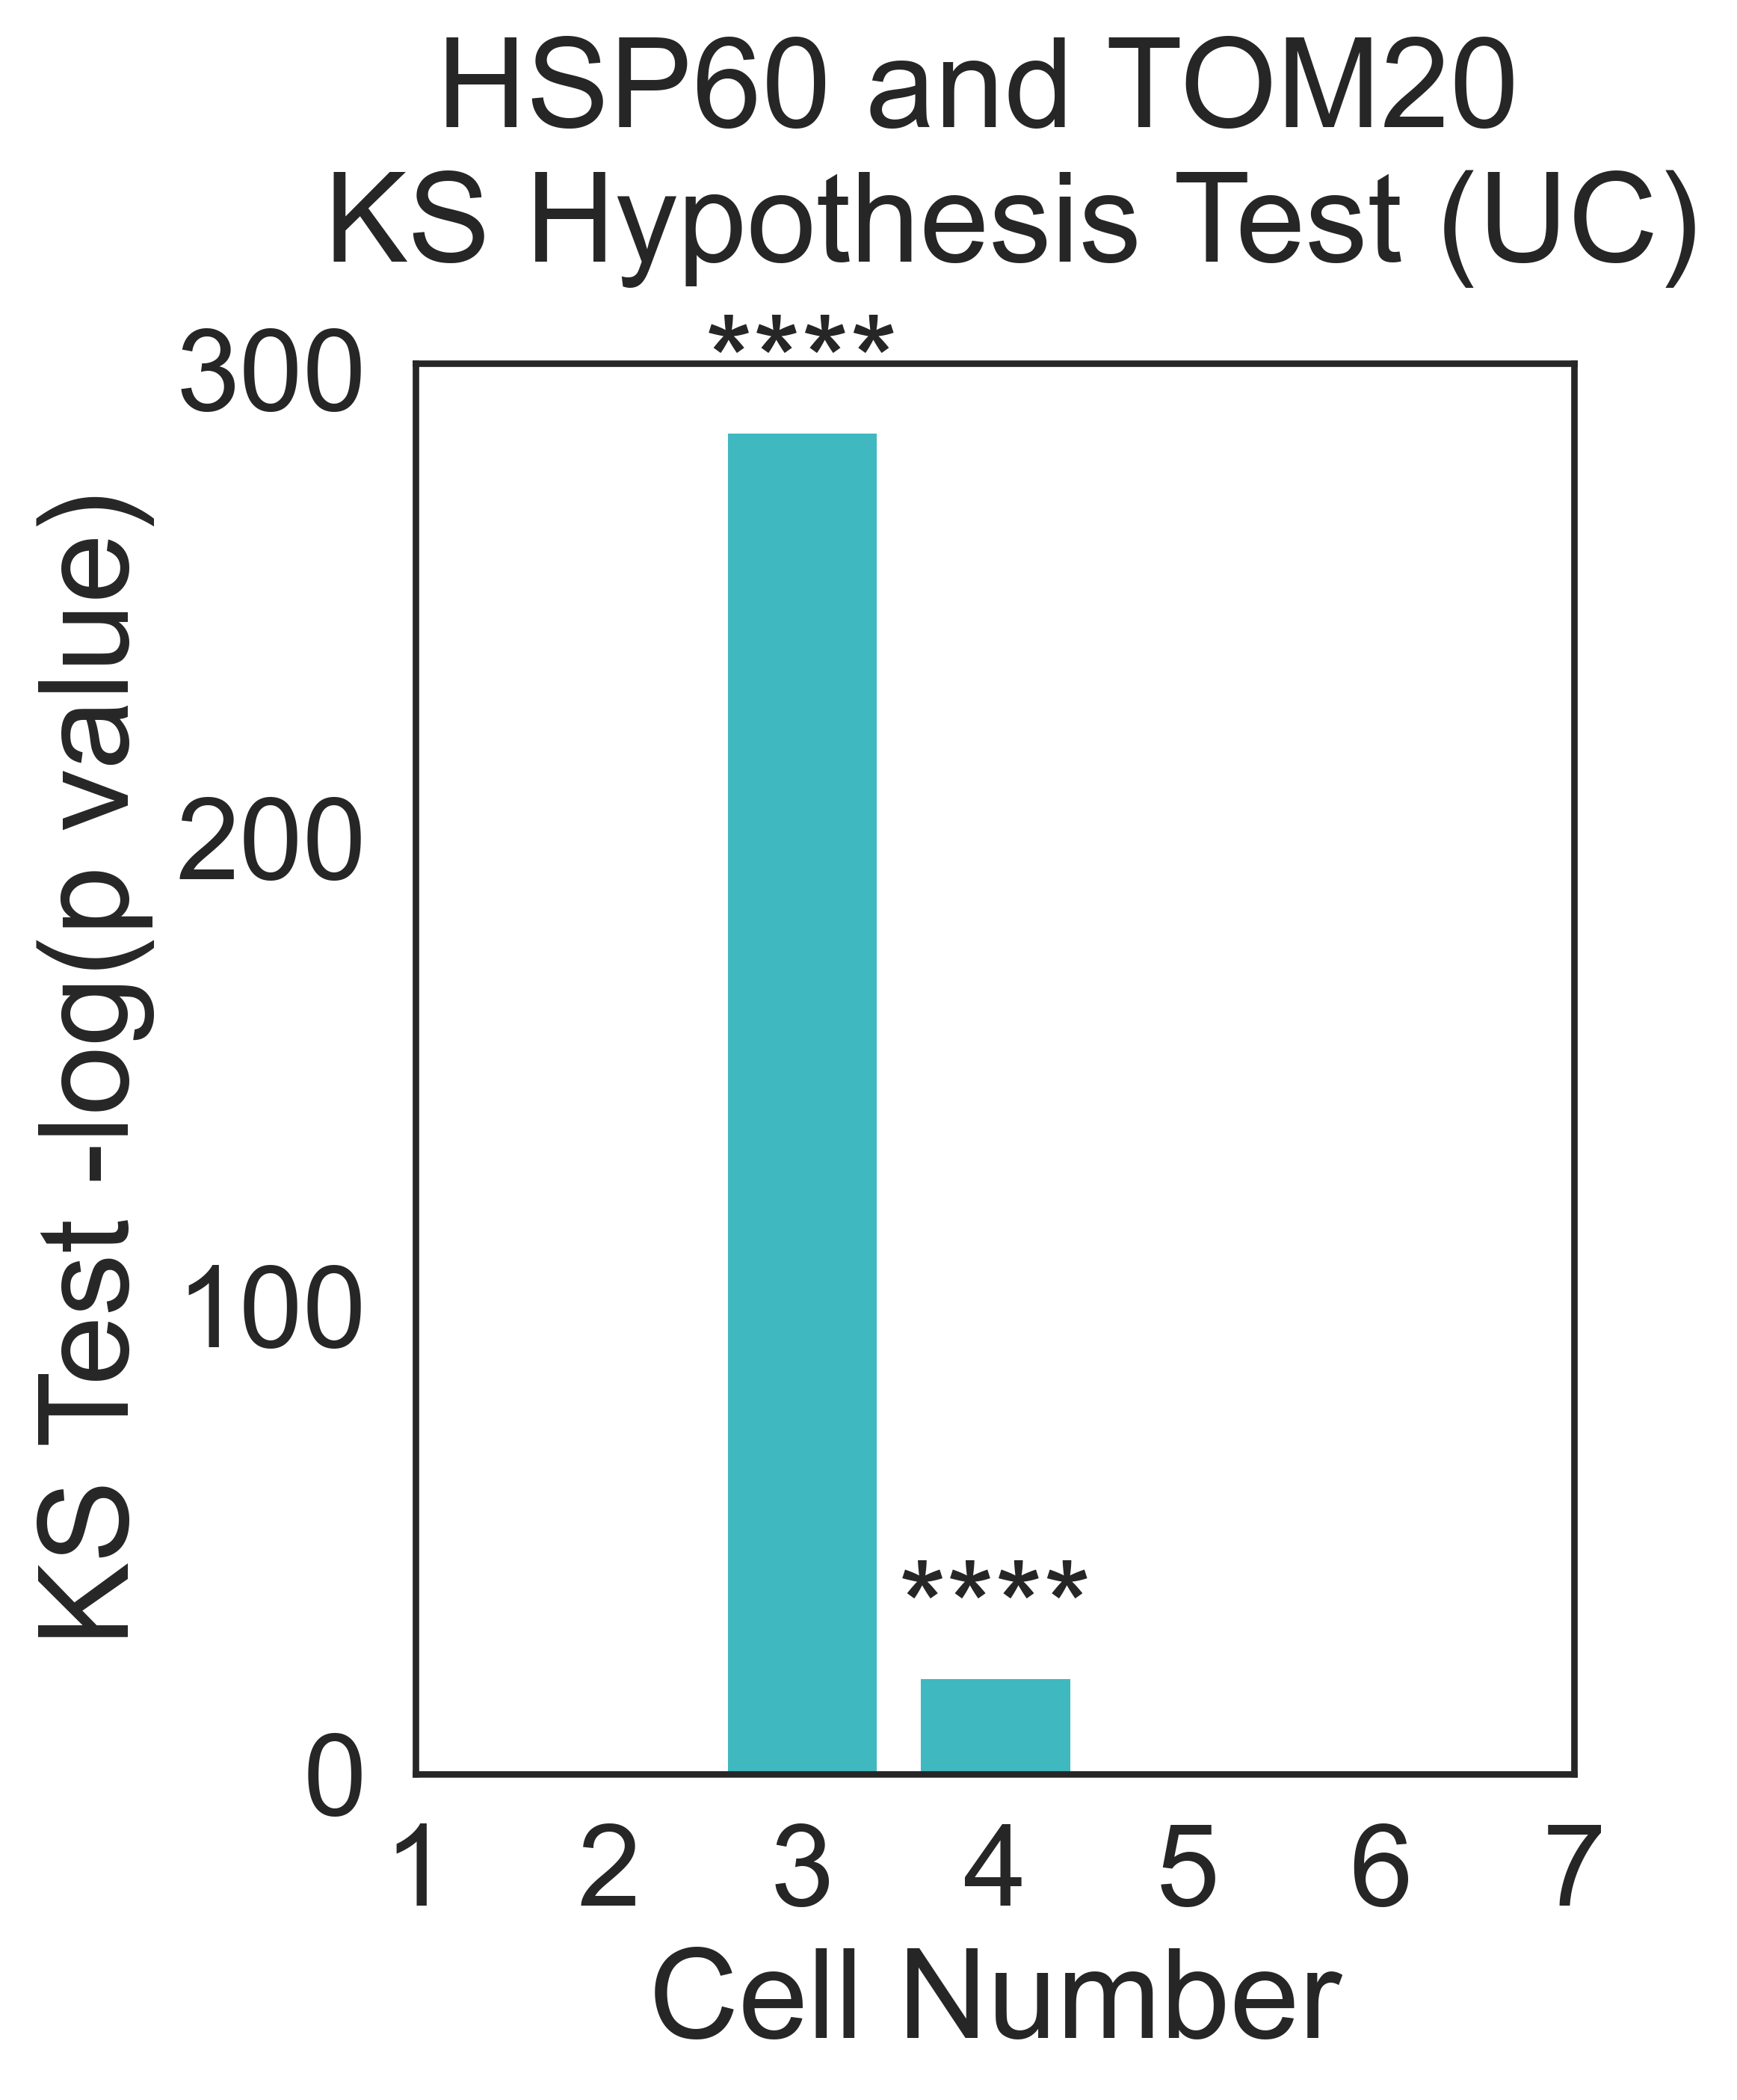

In [31]:
# calculate pairwise markers: HSP60, Tom20
# should be insignificant bc both target mitochondria
centerPVal = {}
centerPVal['BM'] = []
centerPVal['UC'] = []
sigLabels = {}
sigLabels['BM'] = []
sigLabels['UC'] = []

nCells = np.max(images_all_BM['cell'].values)

for c in trange(nCells + 1): # every cell
    
    # test pairwise HSP60 and Tom20 for BM
    dfCell = images_all_BM.loc[images_all_BM['cell'] == c]
    
    # find distance distributions for g4 and sor
    d1 = dfCell.loc[dfCell['HSP60'] > 0] # positive signal
    d1 = d1['DistCenter'].values
    
    d2 = dfCell.loc[dfCell['TOM20'] > 0]
    d2 = d2['DistCenter'].values
    
    _, pVal = scipy.stats.ks_2samp(d1, d2)
    
    if pVal < 0.05 and pVal > 0.01: 
        sigLabels['BM'].append('*')
    elif pVal < 0.01 and pVal > 1e-3:
        sigLabels['BM'].append('**')
    elif pVal < 1e-3 and pVal > 1e-4:
        sigLabels['BM'].append('***')
    elif pVal < 1e-4:
        sigLabels['BM'].append('****')
    else: # insignificant
        sigLabels['BM'].append('')
        
    centerPVal['BM'].append(pVal)
    
    # test pairwise HSP60 and Tom20 for UC
    dfCell = images_all_UC.loc[images_all_UC['cell'] == c]
    
    # find distance distributions for g4 and sor
    d1 = dfCell.loc[dfCell['HSP60'] > 0] # positive signal
    d1 = d1['DistCenter'].values
    
    d2 = dfCell.loc[dfCell['TOM20'] > 0]
    d2 = d2['DistCenter'].values
    
    _, pVal = scipy.stats.ks_2samp(d1, d2)
    
    if pVal < 0.05 and pVal > 0.01: 
        sigLabels['UC'].append('*')
    elif pVal < 0.01 and pVal > 1e-3:
        sigLabels['UC'].append('**')
    elif pVal < 1e-3 and pVal > 1e-4:
        sigLabels['UC'].append('***')
    elif pVal < 1e-4:
        sigLabels['UC'].append('****')
    else: # insignificant
        sigLabels['UC'].append('')
        
    centerPVal['UC'].append(pVal)

if not os.path.exists(f"{data_figure}/ksTest/"):
    os.makedirs(f"{data_figure}/ksTest/")

# visualize p values on 2 separate bar graphs
fig, ax = plt.subplots(dpi = 500, figsize=(4,5))
# grouped bar graph
x = np.arange(1, nCells + 2)  # the label locations
width = 0.35  # the width of the bars

colors = sns.hls_palette(2, l=0.5, s=0.5)

# show negative log values
centerPVal['BM'] = -1 * np.log10(np.array(centerPVal['BM']))
centerPVal['UC'] = -1 * np.log10(np.array(centerPVal['UC']))

# plot separately bc yscale doesn't show everything even on log
rects1 = ax.bar(x, centerPVal['BM'], label = 'BM', color = colors[0])
ax.set_xlabel('Cell Number')
ax.set_ylabel('KS Test -log(p value)')
ax.set_title('HSP60 and TOM20 \n KS Hypothesis Test (BM)', y = 1.05)
# ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7])
# add significance stars
add_value_labels(ax = ax, label = sigLabels['BM'], spacing = 0)
image_path_png = f"{data_figure}/ksTest/hsp60_tom20_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")

fig, ax = plt.subplots(dpi = 500, figsize=(4,5))
ax.bar(x, centerPVal['UC'], label = 'UC', color = colors[1])
ax.set_xlabel('Cell Number')
ax.set_ylabel('KS Test -log(p value)')
ax.set_title('HSP60 and TOM20 \n KS Hypothesis Test (UC)', y = 1.05)
# ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7])
# add significance stars
add_value_labels(ax = ax, label = sigLabels['UC'], spacing = 0)
image_path_png = save_path+"/hsp60_tom20_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")


In [22]:
centerPVal

{'BM': array([105.30905042,          inf,          inf,  29.44233364,
         66.97990343, 189.88771351,  90.35541846]),
 'UC': array([         inf,          inf, 287.05033156,  20.96678265,
                 inf,          inf,          inf])}

In [23]:
# format table for supplementary
tbl1 = pd.DataFrame(centerPVal)
tbl1.index += 1 # cell num
tbl1

,BM,UC
1,105.309050,inf
2,inf,inf
3,inf,287.050332
4,29.442334,20.966783
5,66.979903,inf
6,189.887714,inf
7,90.355418,inf


100%|█████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.74it/s]
C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_97848/32038117.py:70: RuntimeWarning: divide by zero encountered in log10
  centerPVal['BM'] = -1 * np.log10(np.array(centerPVal['BM']))
C:\Users\NZHANG~1\AppData\Local\Temp/ipykernel_97848/32038117.py:71: RuntimeWarning: divide by zero encountered in log10
  centerPVal['UC'] = -1 * np.log10(np.array(centerPVal['UC']))


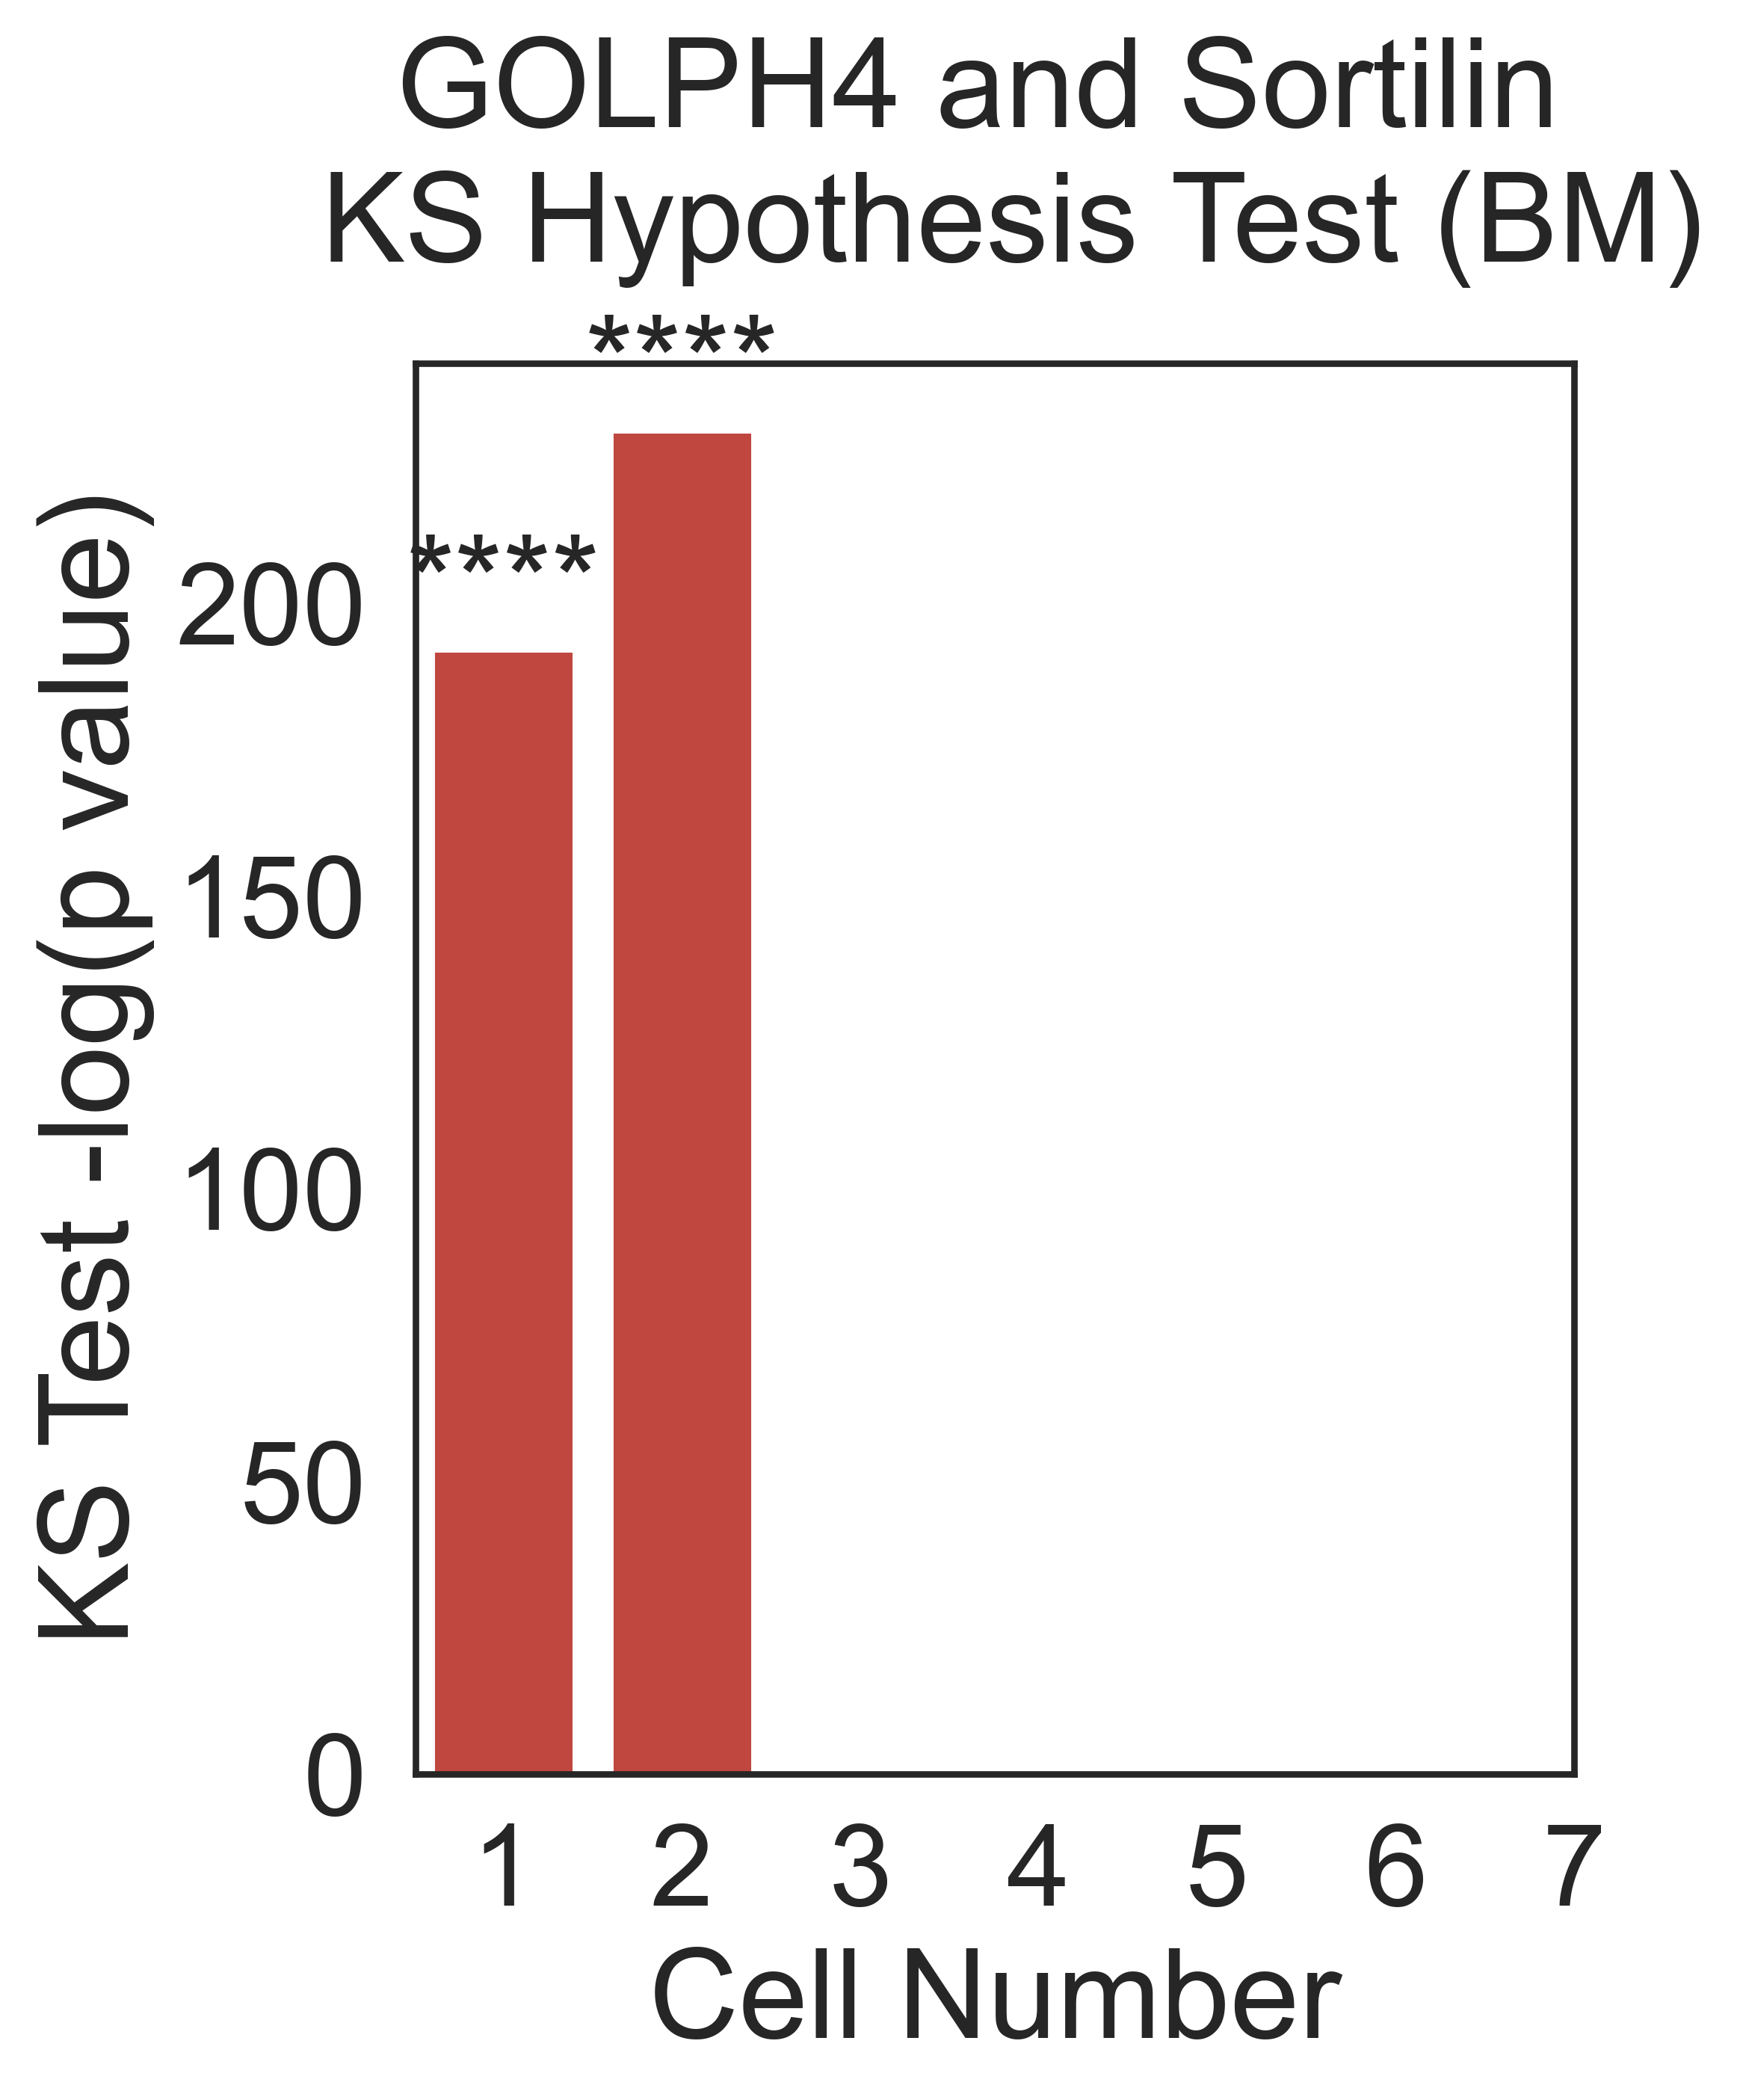

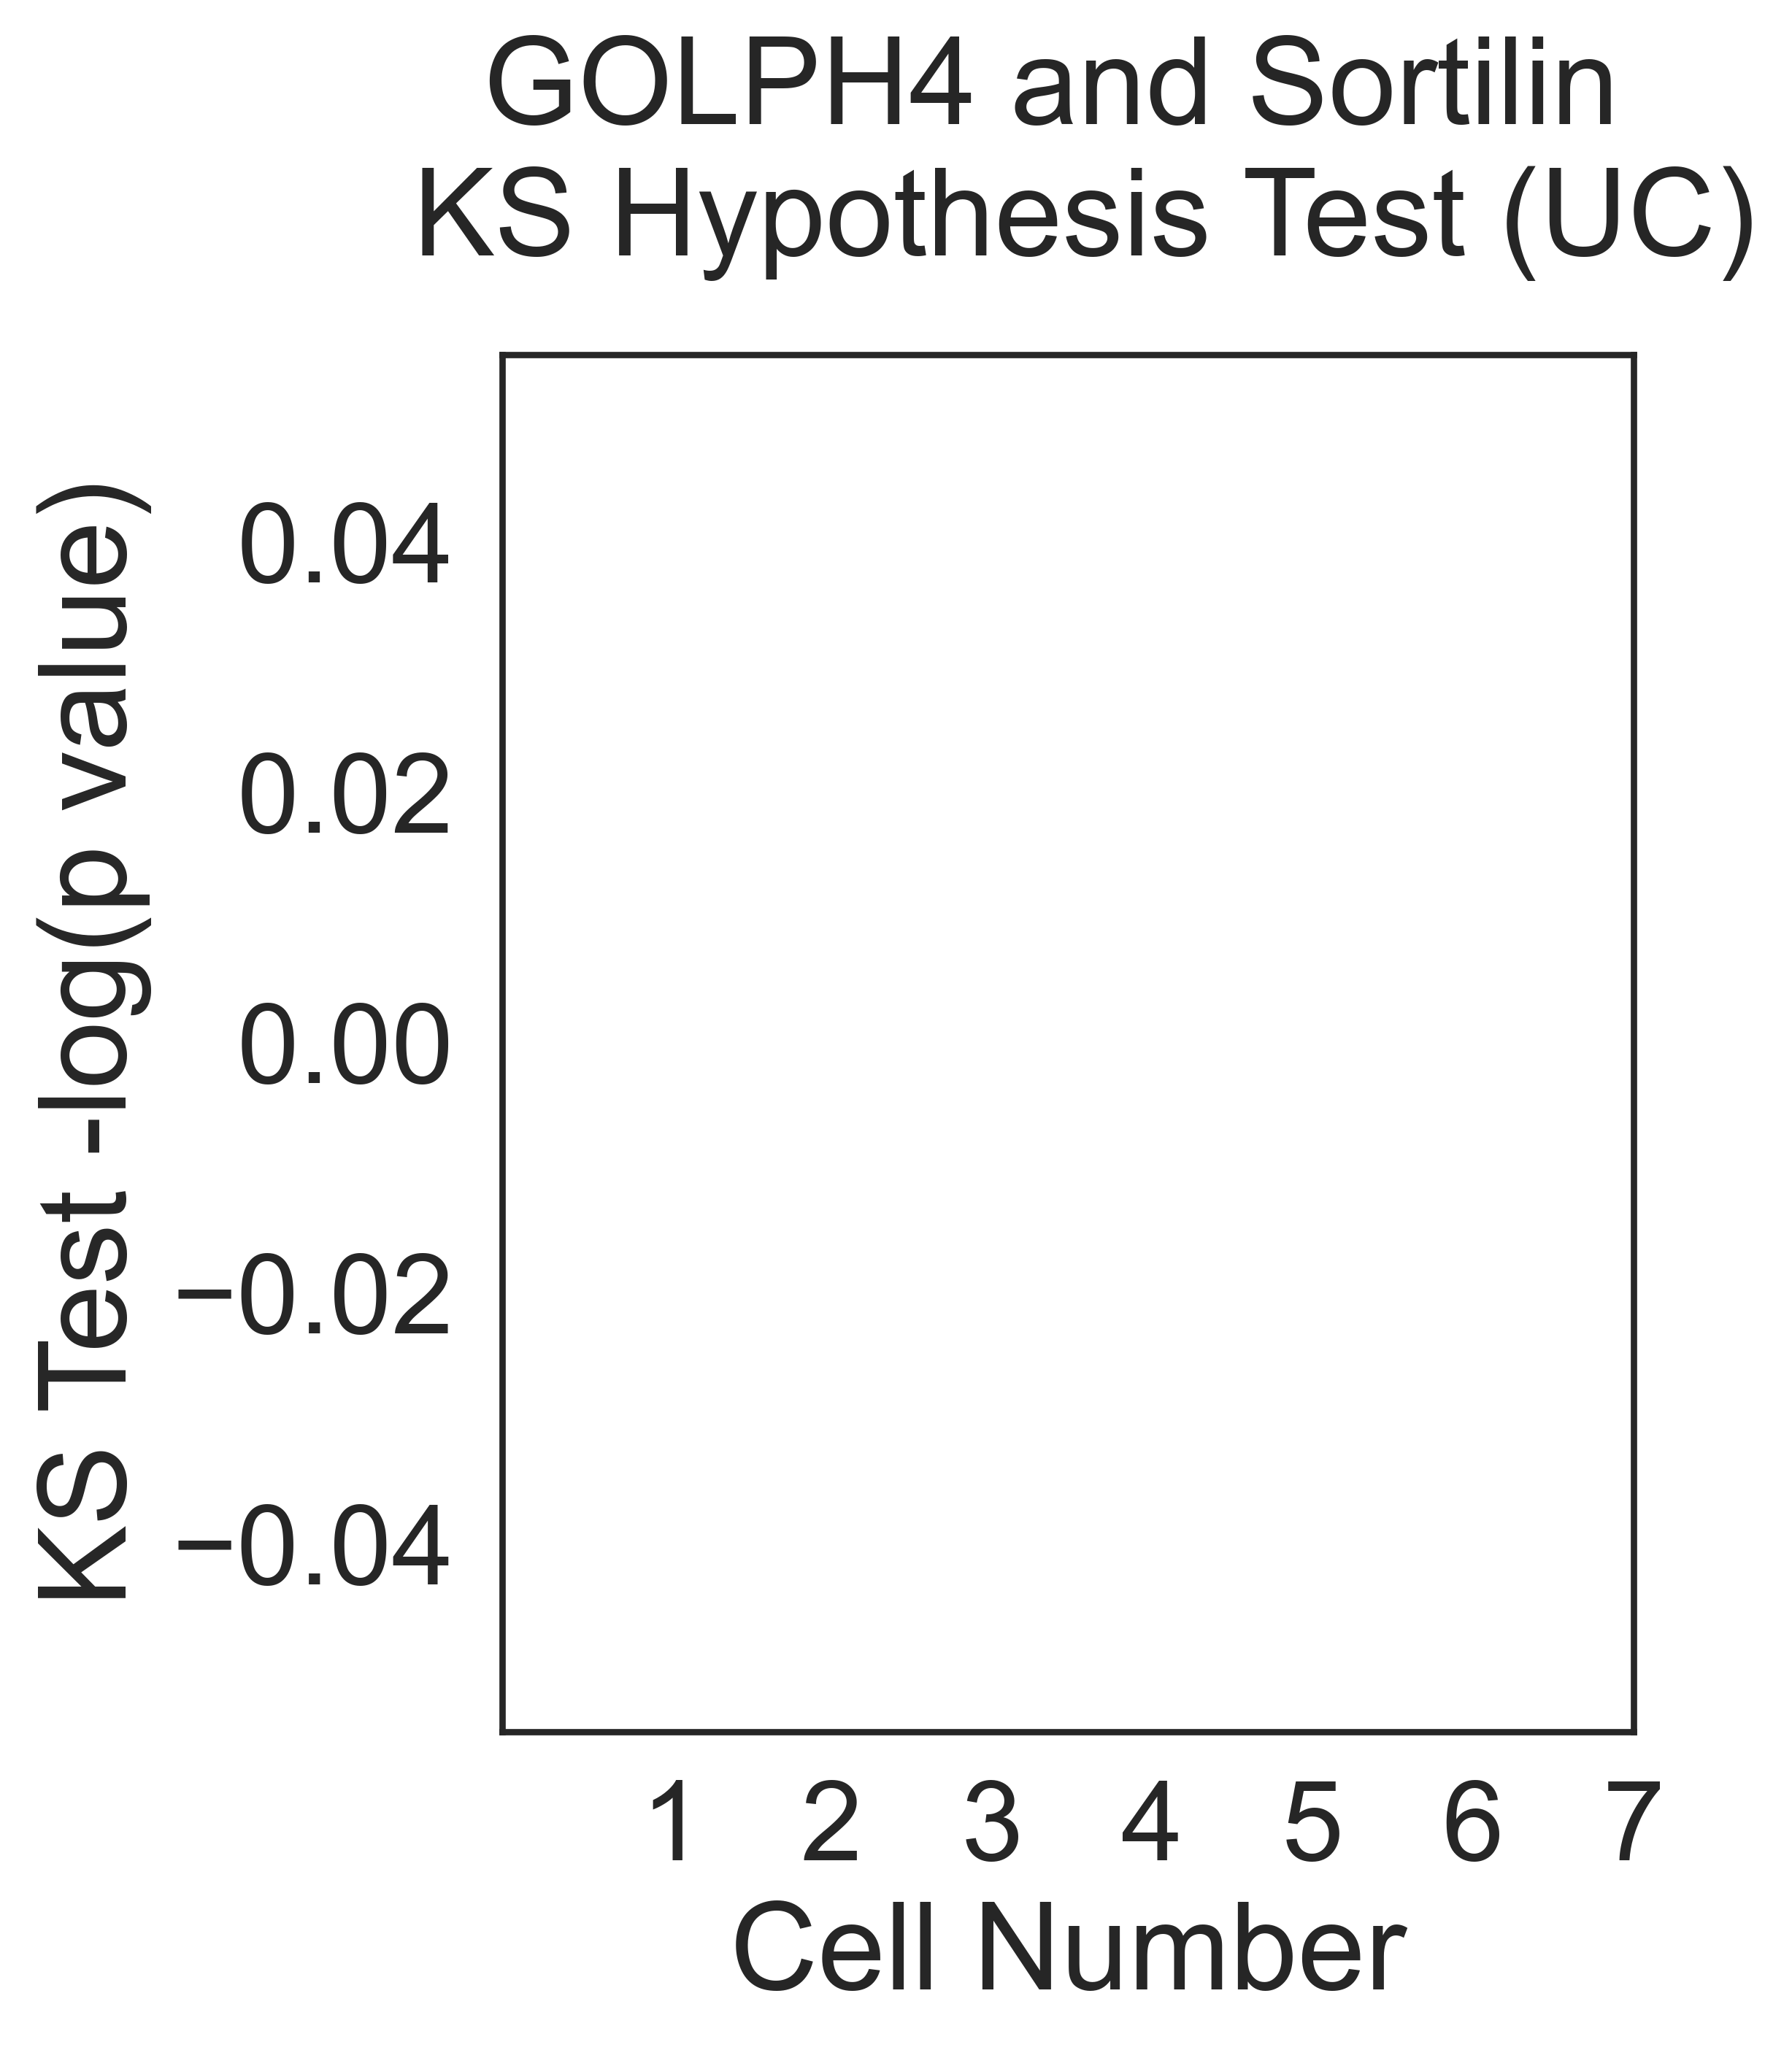

In [32]:
# calculate pairwise markers: GOLPH4, Sortilin
# should be insignificant bc both target golgi
centerPVal = {} # for BM and UC
centerPVal['BM'] = []
centerPVal['UC'] = []
sigLabels = {} # for BM and UC
sigLabels['BM'] = []
sigLabels['UC'] = []
for c in trange(nCells + 1): # every cell
    
    # test pairwise g4 and sor
    dfCell = images_all_BM.loc[images_all_BM['cell'] == c]
    
    # find distance distributions for g4 and sor
    d1 = dfCell.loc[dfCell['GOLPH4'] > 0] # positive signal
    d1 = d1['DistCenter'].values
    
    d2 = dfCell.loc[dfCell['Sortilin'] > 0]
    d2 = d2['DistCenter'].values
    
    _, pVal = scipy.stats.ks_2samp(d1, d2)
    
    if pVal < 0.05 and pVal > 0.01: 
        sigLabels['BM'].append('*')
    elif pVal < 0.01 and pVal > 1e-3:
        sigLabels['BM'].append('**')
    elif pVal < 1e-3 and pVal > 1e-4:
        sigLabels['BM'].append('***')
    elif pVal < 1e-4:
        sigLabels['BM'].append('****')
    else: # insignificant
        sigLabels['BM'].append('')

    centerPVal['BM'].append(pVal)
    
    # repeat for UC
    dfCell = images_all_UC.loc[images_all_UC['cell'] == c]
    
    # find distance distributions for g4 and sor
    d1 = dfCell.loc[dfCell['GOLPH4'] > 0] # positive signal
    d1 = d1['DistCenter'].values
    
    d2 = dfCell.loc[dfCell['Sortilin'] > 0]
    d2 = d2['DistCenter'].values
    
    _, pVal = scipy.stats.ks_2samp(d1, d2)
    
    if pVal < 0.05 and pVal > 0.01: 
        sigLabels['UC'].append('*')
    elif pVal < 0.01 and pVal > 1e-3:
        sigLabels['UC'].append('**')
    elif pVal < 1e-3 and pVal > 1e-4:
        sigLabels['UC'].append('***')
    elif pVal < 1e-4:
        sigLabels['UC'].append('****')
    else: # insignificant
        sigLabels['UC'].append('')

    centerPVal['UC'].append(pVal)

if not os.path.exists(f"{data_figure}/ksTest/"):
    os.makedirs(f"{data_figure}/ksTest/")

fig, ax = plt.subplots(dpi = 500, figsize=(4,5))
# grouped bar graph
x = np.arange(1, nCells + 2)  # the label locations
width = 0.35  # the width of the bars

# show negative log values
centerPVal['BM'] = -1 * np.log10(np.array(centerPVal['BM']))
centerPVal['UC'] = -1 * np.log10(np.array(centerPVal['UC']))

# plot separately bc yscale doesn't show everything even on log
colors = sns.hls_palette(2, l=0.5, s=0.5)
rects1 = ax.bar(x, centerPVal['BM'], label = 'BM', color = colors[0])
ax.set_xlabel('Cell Number')
ax.set_ylabel('KS Test -log(p value)')
ax.set_title('GOLPH4 and Sortilin \n KS Hypothesis Test (BM)', y = 1.05)
# ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7])
# add significance stars
add_value_labels(ax = ax, label = sigLabels['BM'], spacing = 0)
image_path_png = f"{data_figure}/ksTest/golph4_sortilin_BM.png"
plt.savefig(image_path_png, bbox_inches="tight")

fig, ax = plt.subplots(dpi = 500, figsize=(4,5))
ax.bar(x, centerPVal['UC'], label = 'UC', color = colors[1])
ax.set_xlabel('Cell Number')
ax.set_ylabel('KS Test -log(p value)')
ax.set_title('GOLPH4 and Sortilin \n KS Hypothesis Test (UC)', y = 1.05)
# ax.set_yscale('log')
ax.set_xticks([1,2,3,4,5,6,7])
# add significance stars
add_value_labels(ax = ax, label = sigLabels['UC'], spacing = 0)
image_path_png = save_path+"/golph4_sortilin_UC.png"
plt.savefig(image_path_png, bbox_inches="tight")

In [25]:
# format table for supplementary
tbl2 = pd.DataFrame(centerPVal)
tbl2.index += 1 # cell num
tbl2

,BM,UC
1,192.092697,inf
2,229.594915,inf
3,inf,inf
4,inf,inf
5,inf,inf
6,inf,inf
7,inf,inf


In [26]:
tbl = pd.concat([tbl1, tbl2], axis = 1)
tbl

,BM,UC,BM,UC
1,105.309050,inf,192.092697,inf
2,inf,inf,229.594915,inf
3,inf,287.050332,inf,inf
4,29.442334,20.966783,inf,inf
5,66.979903,inf,inf,inf
6,189.887714,inf,inf,inf
7,90.355418,inf,inf,inf


In [27]:
# export table to excel
fileOut = os.path.join(save_path, 'KS_test_pVals.xlsx')
tbl.to_excel(fileOut)